# Aprendizado de Máquina - Trabalho 2

Nome: Matheus dos Santos Moura <br>
Matrícula: 2410003MCICMA

URL do vídeo: https://youtu.be/qXE7f0Rt5qA

| Questão | Tempo |
|---------|-------|
| 1       | 00:16 |
| 2       | 02:33 |
| 3       | 08:48 |
| 4       | 11:36 |
| 5       | 14:50 |

In [1]:
from pprint import pprint
from typing import Callable, List, Union, Optional
import warnings

import category_encoders
from lightgbm import LGBMRegressor
from mapie.metrics import regression_coverage_score, regression_mean_width_score
from mapie.regression import MapieQuantileRegressor
from matplotlib.offsetbox import AnnotationBbox, TextArea
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import numpy as np
import pandas as pd
import seaborn as sn
import shap


SEED = 42
sklearn.set_config(transform_output = "pandas")
shap.initjs() 
warnings.filterwarnings("ignore")

## 1 - Engenharia de Features

- Considere novamente o mesmo problema da questão 1 do T1.
- Utilize os mesmos conjuntos de dados, mas investigue outras técnicas de codificação.
- Utilize apenas um dos algoritmos de aprendizado de máquina.
- Realize uma análise comparativa deste experimento frente aos resultados do T1.

In [2]:
# Loading datasets

q1_column_names = [
    "ESCT",
    "NDEP",
    "RENDA",
    "TIPOR",
    "VBEM",
    "NPARC",
    "VPARC",
    "TEL",
    "IDADE",
    "RESMS",
    "ENTRADA",
    "CLASSE"
]

q1_df_train = pd.read_csv("../data/credtrain.txt", sep="\t", names=q1_column_names)
q1_df_test = pd.read_csv("../data/credtest.txt", sep="\t", names=q1_column_names)

q1_df_train.head()

,ESCT,NDEP,RENDA,TIPOR,VBEM,NPARC,VPARC,TEL,IDADE,RESMS,ENTRADA,CLASSE
0,1,0,360,0,313,9,52,0,25,48,0,1
1,0,0,350,1,468,10,65,0,33,6,0,1
2,0,0,1100,0,829,9,125,0,56,48,0,1
3,0,0,3000,0,552,12,76,1,31,60,0,1
4,1,0,1000,0,809,12,111,0,24,7,0,1


In [3]:
# Defining feature encoders

q1_transformers_list = [
    ("ohot", OneHotEncoder(sparse_output = False, drop = "first"), ["ESCT"]),
    ("woev", category_encoders.WOEEncoder(drop_invariant = True), ["TIPOR", "TEL"]),
    ("tget", category_encoders.TargetEncoder(), ["NDEP"])
]

q1_fe_pipeline = ColumnTransformer(
    transformers = q1_transformers_list,
    remainder = "passthrough",
    verbose_feature_names_out = False
)

In [4]:
q1_df_train["ESCT"] = q1_df_train["ESCT"].astype(str)
q1_df_train["TIPOR"] = q1_df_train["TIPOR"].astype(str)
q1_df_train["TEL"] = q1_df_train["TEL"].astype(str)
q1_df_train["NDEP"] = q1_df_train["NDEP"].astype(str)
q1_df_train.head()

,ESCT,NDEP,RENDA,TIPOR,VBEM,NPARC,VPARC,TEL,IDADE,RESMS,ENTRADA,CLASSE
0,1,0,360,0,313,9,52,0,25,48,0,1
1,0,0,350,1,468,10,65,0,33,6,0,1
2,0,0,1100,0,829,9,125,0,56,48,0,1
3,0,0,3000,0,552,12,76,1,31,60,0,1
4,1,0,1000,0,809,12,111,0,24,7,0,1


In [5]:
# Encoding features
q1_encoded_df_train = q1_fe_pipeline.fit_transform(
    q1_df_train, q1_df_train.CLASSE.values
)
q1_encoded_df_train.head()

,ESCT_1,ESCT_2,ESCT_3,TIPOR,TEL,NDEP,RENDA,VBEM,NPARC,VPARC,IDADE,RESMS,ENTRADA,CLASSE
0,1.0,0.0,0.0,0.924514,-0.105810,0.48687,360,313,9,52,25,48,0,1
1,0.0,0.0,0.0,-1.274589,-0.105810,0.48687,350,468,10,65,33,6,0,1
2,0.0,0.0,0.0,0.924514,-0.105810,0.48687,1100,829,9,125,56,48,0,1
3,0.0,0.0,0.0,0.924514,0.691684,0.48687,3000,552,12,76,31,60,0,1
4,1.0,0.0,0.0,0.924514,-0.105810,0.48687,1000,809,12,111,24,7,0,1


In [6]:
# Separating features matrix and target column
q1_X_train = q1_encoded_df_train.drop(["CLASSE"], axis=1)
q1_y_train = q1_encoded_df_train.CLASSE.values
q1_X_train.head()

,ESCT_1,ESCT_2,ESCT_3,TIPOR,TEL,NDEP,RENDA,VBEM,NPARC,VPARC,IDADE,RESMS,ENTRADA
0,1.0,0.0,0.0,0.924514,-0.105810,0.48687,360,313,9,52,25,48,0
1,0.0,0.0,0.0,-1.274589,-0.105810,0.48687,350,468,10,65,33,6,0
2,0.0,0.0,0.0,0.924514,-0.105810,0.48687,1100,829,9,125,56,48,0
3,0.0,0.0,0.0,0.924514,0.691684,0.48687,3000,552,12,76,31,60,0
4,1.0,0.0,0.0,0.924514,-0.105810,0.48687,1000,809,12,111,24,7,0


In [7]:
# Scaling data
q1_encoded_column_names_backup = q1_X_train.columns
q1_scaler = MinMaxScaler()
q1_scaled_X_train = pd.DataFrame(
    q1_scaler.fit_transform(q1_X_train), columns=q1_encoded_column_names_backup
)
q1_scaled_X_train.head()

,ESCT_1,ESCT_2,ESCT_3,TIPOR,TEL,NDEP,RENDA,VBEM,NPARC,VPARC,IDADE,RESMS,ENTRADA
0,1.0,0.0,0.0,1.0,0.0,1.0,0.007792,0.003514,0.347826,0.003026,0.117647,0.114286,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.006494,0.045405,0.391304,0.022693,0.274510,0.014286,0.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.103896,0.142973,0.347826,0.113464,0.725490,0.114286,0.0
3,0.0,0.0,0.0,1.0,1.0,1.0,0.350649,0.068108,0.478261,0.039334,0.235294,0.142857,0.0
4,1.0,0.0,0.0,1.0,0.0,1.0,0.090909,0.137568,0.478261,0.092284,0.098039,0.016667,0.0


In [8]:
# Model training
q1_models = [
    GradientBoostingClassifier(random_state=SEED),
]

q1_training_accuracies = {}

for model in q1_models:
    model.fit(q1_scaled_X_train, q1_y_train)
    q1_training_accuracies[model.__class__.__name__] = model.score(
        q1_scaled_X_train, q1_y_train
    )

print("Training accuracies")
pprint(q1_training_accuracies, sort_dicts=False)

Training accuracies
{'GradientBoostingClassifier': 0.9366666666666666}


In [9]:
# Processing test dataset

q1_df_test["ESCT"] = q1_df_test["ESCT"].astype(str)
q1_df_test["TIPOR"] = q1_df_test["TIPOR"].astype(str)
q1_df_test["TEL"] = q1_df_test["TEL"].astype(str)
q1_df_test["NDEP"] = q1_df_test["NDEP"].astype(str)

q1_encoded_df_test = q1_fe_pipeline.fit_transform(q1_df_test, q1_df_test.CLASSE.values)
q1_X_test = q1_encoded_df_test.drop(["CLASSE"], axis=1)
q1_y_test = q1_encoded_df_test.CLASSE.values
q1_scaled_X_test = pd.DataFrame(
    q1_scaler.transform(q1_X_test), columns=q1_encoded_column_names_backup
)

q1_scaled_X_test.head()

,ESCT_1,ESCT_2,ESCT_3,TIPOR,TEL,NDEP,RENDA,VBEM,NPARC,VPARC,IDADE,RESMS,ENTRADA
0,0.0,0.0,0.0,-0.002455,0.049056,0.533025,0.025974,0.085946,0.391304,0.052950,0.333333,0.014286,0.000000
1,1.0,0.0,0.0,1.008897,0.049056,0.943545,0.066623,0.068108,0.130435,0.104387,0.470588,0.114286,0.091538
2,0.0,0.0,1.0,1.008897,0.049056,0.943545,0.006494,0.050811,0.478261,0.024206,0.470588,0.000000,0.000000
3,1.0,0.0,0.0,1.008897,0.049056,0.943545,0.159740,0.021892,0.000000,0.526475,0.176471,0.114286,0.000000
4,0.0,0.0,0.0,-0.002455,0.049056,0.943545,0.050390,0.025946,0.391304,0.015129,0.588235,0.171429,0.000000


In [10]:
def q1_evaluate_classificator(model, X_test, y_test, target_names: Optional[List[str]] = None):
    predicted_y = model.predict(X_test)
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_test, predicted_y).ravel()
    pprint(
        {
            "Model": model.__class__.__name__,
            "acc": sklearn.metrics.accuracy_score(y_test, predicted_y),
            "tp": tp,
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "Classification Report": sklearn.metrics.classification_report(
                y_test, predicted_y, output_dict = True, target_names = target_names
            ),
        },
        sort_dicts=False,
    )

In [11]:
q1_evaluate_classificator(q1_models[0], q1_scaled_X_test, q1_y_test)

{'Model': 'GradientBoostingClassifier',
 'acc': 0.9064124783362218,
 'tp': 227,
 'tn': 296,
 'fp': 10,
 'fn': 44,
 'Classification Report': {'0': {'precision': 0.8705882352941177,
                                 'recall': 0.9673202614379085,
                                 'f1-score': 0.9164086687306502,
                                 'support': 306.0},
                           '1': {'precision': 0.9578059071729957,
                                 'recall': 0.8376383763837638,
                                 'f1-score': 0.8937007874015748,
                                 'support': 271.0},
                           'accuracy': 0.9064124783362218,
                           'macro avg': {'precision': 0.9141970712335568,
                                         'recall': 0.9024793189108362,
                                         'f1-score': 0.9050547280661125,
                                         'support': 577.0},
                           'weighted avg': {'precision': 

### Comparação dos Resultados

| Métricas |   T1   |   T2   |
|----------|--------|--------|
| Acurácia | 90.12% | 90.64% |
| Precisão | 95.73% | 95.78% |
| Recall   | 82.66% | 83.76% |
| F1       | 88.71% | 89.37% |

## 2 - Classificação Multi-classe

- Utilize os dados das estações meteorológicas: `A602`, `A621`, `A627`, `A636` e `A652`.
- Ao invés de binarizar a classe como no trabalho 1, desta vez, enquadre o problema como uma tarefa de classificação multi-classes.
- Crie modelos de classificação para o conjunto de dados usando o algoritmo **GradientBoostingClassifier** equipado com a técnica de regularização **Early Stopping**.
- Apresente a **curva de aprendizado** correspondente ao treinamento dos modelos.
- Apresente seus resultados com o plot de uma **matriz de confusão** e utilizando a função **classification_report** do Scikit-Learn.
- Apresente uma análise comparativa com os resultados correspondentes do Trabalho 1.

### Tabela das Classes de Precipitação

| Precipitação |   Classe   |
|--------------|------------|
| 0            |    NONE    |
| (0, 5]       |    WEAK    |
| (5, 25]      |  MODERATE  |
| (25, 50]     |   STRONG   |
|(50, $\infty$]|   EXTREME  |

In [12]:
Q2_TARGET_COLUMN = "precipitation"

In [13]:
def q2_load_datasets(file_name: str) -> pd.DataFrame:
    FILE_PATH = "../data/atmoseer/"
    df_train = pd.read_parquet(FILE_PATH + file_name + "_train.parquet.gzip")
    df_val = pd.read_parquet(FILE_PATH + file_name + "_val.parquet.gzip")
    df_test = pd.read_parquet(FILE_PATH + file_name + "_test.parquet.gzip")
    return df_train, df_val, df_test

In [14]:
def q2_label_target_column(map_function: Callable, column_name: str, *dataframes: pd.DataFrame) -> List[pd.DataFrame]:
    result = []
    for df in dataframes:
        df[column_name] = df[column_name].map(map_function)
        result.append(df)

    return result


In [15]:
def q2_compute_precipitation_class(precipitation_value: Union[int, float]) -> str:
    if precipitation_value < 0:
        raise ValueError("precipitation_value cannot be less than 0")
    elif precipitation_value == 0:
        return "NONE"
    elif precipitation_value <= 5:
        return "WEAK"
    elif precipitation_value <= 25:
        return "MODERATE"
    elif precipitation_value <= 50:
        return "STRONG"
    else:
        return "EXTREME"

In [16]:
def q2_plot_multiclass_confusion_matrix(array: List[int], labels: List[str]) -> None:
    # Lines represent the real label
    # Columns are the predicted label
    df_cm = pd.DataFrame(array, index = labels, columns = labels)
    plt.figure(figsize = (10, 7))
    sn.heatmap(df_cm, annot = True, fmt = "g")

In [17]:
def q2_precipitation_filter_classes(df: pd.DataFrame, cv_n_splits: int) -> pd.DataFrame:
    ban_list = []
    ban_list_sample_count = 0

    for class_name, count in zip(*np.unique(df.precipitation.values, return_counts = True)):
        if count < cv_n_splits * 2:
            ban_list.append(class_name)
            ban_list_sample_count += count

    if ban_list_sample_count >= cv_n_splits * 2:
        df[Q2_TARGET_COLUMN] = df[Q2_TARGET_COLUMN].map(lambda x: x if x not in ban_list else "BANNED")
    else:
        df = df[~df[Q2_TARGET_COLUMN].isin(ban_list)]

    return df

In [18]:
def q2_plot_learning_curve(model, df: pd.DataFrame):
    cv_n_splits = 5
    df = q2_precipitation_filter_classes(df, cv_n_splits)

    train_sizes, train_scores, test_scores = sklearn.model_selection.learning_curve(
        estimator = model,
        X = df.drop(Q2_TARGET_COLUMN, axis = 1),
        y = df.precipitation.values,
        cv = sklearn.model_selection.StratifiedKFold(n_splits = cv_n_splits),
        scoring = "f1_macro",
        train_sizes = np.linspace(0.2, 1.0, 5),
        n_jobs = -1,
        error_score = 'raise',
        random_state = SEED
    )

    train_mean = train_scores.mean(axis = 1)
    test_mean = test_scores.mean(axis = 1)

    plt.subplots(figsize = (10, 7))
    plt.plot(train_sizes, train_mean, label = "train")
    plt.plot(train_sizes, test_mean, label = "validation")

    plt.title("Learning Curve")
    plt.xlabel("Number of training examples")
    plt.ylabel("Score")
    plt.legend(loc = "best")
    plt.show()

In [19]:
def q2_main(file_name: str) -> None:
    df_train, df_val, df_test = q2_load_datasets(file_name)

    df_train, df_val, df_test = q2_label_target_column(
        q2_compute_precipitation_class, Q2_TARGET_COLUMN, df_train, df_val, df_test
    )

    df_concat = q2_precipitation_filter_classes(pd.concat([df_train, df_val]), 1)
    df_test = q2_precipitation_filter_classes(df_test, 1)

    X_concat = df_concat.drop(Q2_TARGET_COLUMN, axis = 1)
    X_test = df_test.drop(Q2_TARGET_COLUMN, axis = 1)
    y_concat = df_concat.precipitation.values
    y_test = df_test.precipitation.values

    gbc_with_early_stopping = GradientBoostingClassifier(
        validation_fraction = 0.1, n_iter_no_change = 10
    )
    gbc_with_early_stopping.fit(X_concat, y_concat)
    predicted_y = gbc_with_early_stopping.predict(X_test)

    target_names = sorted(["NONE", "WEAK", "MODERATE", "STRONG", "EXTREME", "BANNED"])
    unique_target_names = set(np.unique(predicted_y)).union(np.unique(y_test))
    target_names = [x for x in target_names if x in unique_target_names]

    pprint({
        "File": file_name,
        "Classification Report": sklearn.metrics.classification_report(
            y_test, predicted_y, output_dict = True, target_names = target_names
        ),
    }, sort_dicts = False)

    q2_plot_multiclass_confusion_matrix(
        sklearn.metrics.confusion_matrix(y_test, predicted_y, labels = target_names),
        target_names)

    q2_plot_learning_curve(
        gbc_with_early_stopping,
        df_train)

{'File': 'A602',
 'Classification Report': {'MODERATE': {'precision': 0.0,
                                        'recall': 0.0,
                                        'f1-score': 0.0,
                                        'support': 9.0},
                           'NONE': {'precision': 0.9056338028169014,
                                    'recall': 0.9511834319526628,
                                    'f1-score': 0.9278499278499278,
                                    'support': 676.0},
                           'WEAK': {'precision': 0.4,
                                    'recall': 0.24096385542168675,
                                    'f1-score': 0.3007518796992481,
                                    'support': 83.0},
                           'accuracy': 0.86328125,
                           'macro avg': {'precision': 0.43521126760563383,
                                         'recall': 0.39738242912478317,
                                         'f1-score': 0.40

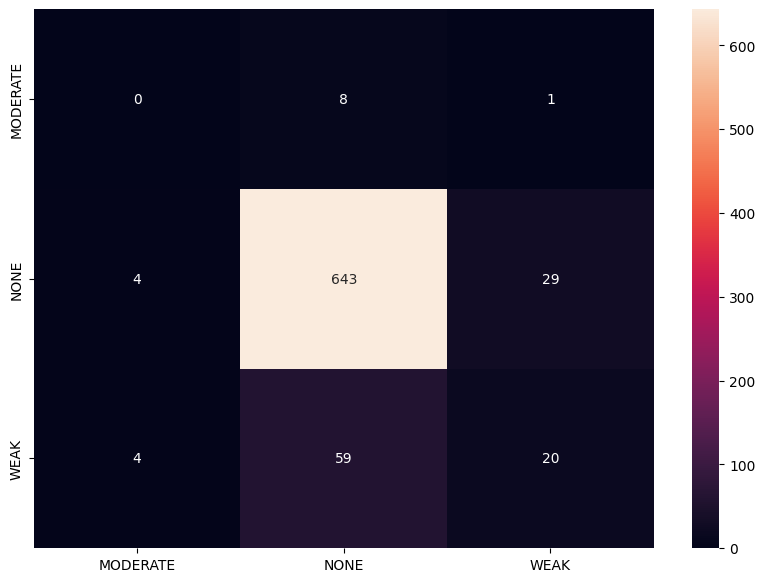

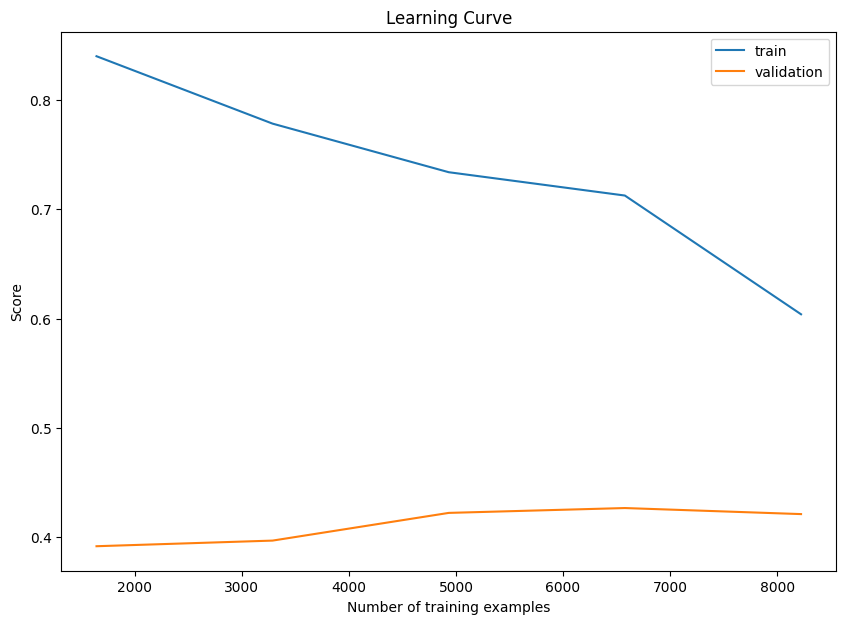

In [20]:
q2_main("A602")

### A602: Comparação dos Resultados Vanilla

| Métricas |   T1 (target == 1)  |   T2 (macro)  |
|----------------|--------|--------|
|    Acurácia    | 87.10% | 86.33% |
|    Precisão    | 44.93% | 33.10% |
|    Recall      | 33.70% | 29.54% |
|    F1          | 38.51% | 30.59% |

{'File': 'A621',
 'Classification Report': {'MODERATE': {'precision': 0.35714285714285715,
                                        'recall': 0.06666666666666667,
                                        'f1-score': 0.11235955056179775,
                                        'support': 75.0},
                           'NONE': {'precision': 0.9315408479834539,
                                    'recall': 0.9831914429163938,
                                    'f1-score': 0.9566694987255735,
                                    'support': 9162.0},
                           'STRONG': {'precision': 0.0,
                                      'recall': 0.0,
                                      'f1-score': 0.0,
                                      'support': 9.0},
                           'WEAK': {'precision': 0.5292682926829269,
                                    'recall': 0.25589622641509435,
                                    'f1-score': 0.3449920508744038,
                         

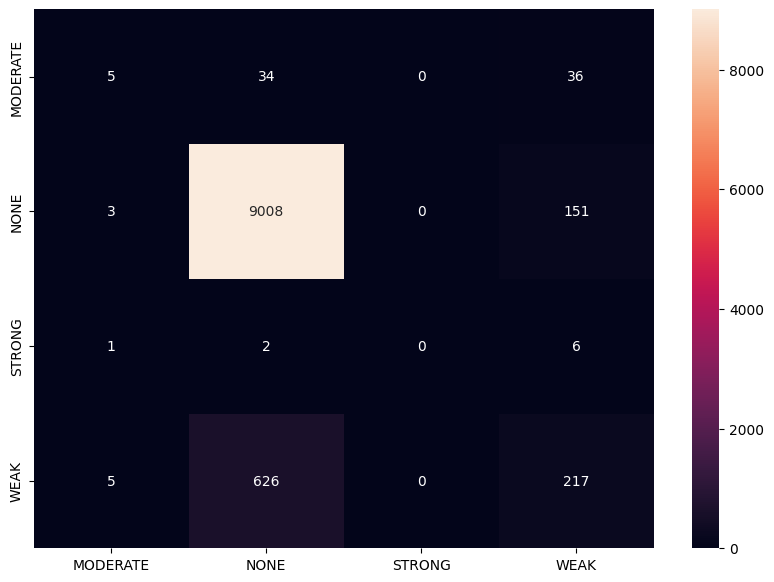

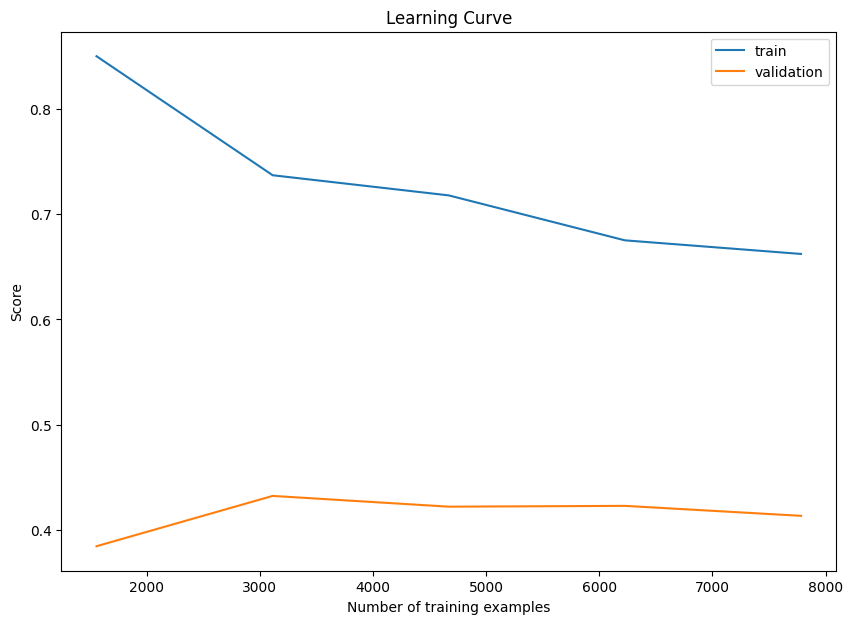

In [21]:
q2_main("A621")

### A621: Comparação dos Resultados Vanilla

| Métricas |   T1 (target == 1)  |   T2 (macro)  |
|----------------|--------|--------|
|    Acurácia    | 91.95% | 91.19% |
|    Precisão    | 63.70% | 40.72% |
|    Recall      | 29.90% | 31.86% |
|    F1          | 40.70% | 34.00% |

{'File': 'A627',
 'Classification Report': {'MODERATE': {'precision': 0.10483870967741936,
                                        'recall': 0.17333333333333334,
                                        'f1-score': 0.1306532663316583,
                                        'support': 75.0},
                           'NONE': {'precision': 0.9542799370927881,
                                    'recall': 0.9218665219750407,
                                    'f1-score': 0.9377932328752001,
                                    'support': 9215.0},
                           'STRONG': {'precision': 0.008547008547008548,
                                      'recall': 0.16666666666666666,
                                      'f1-score': 0.016260162601626018,
                                      'support': 6.0},
                           'WEAK': {'precision': 0.40875232774674114,
                                    'recall': 0.4766558089033659,
                                    'f1-scor

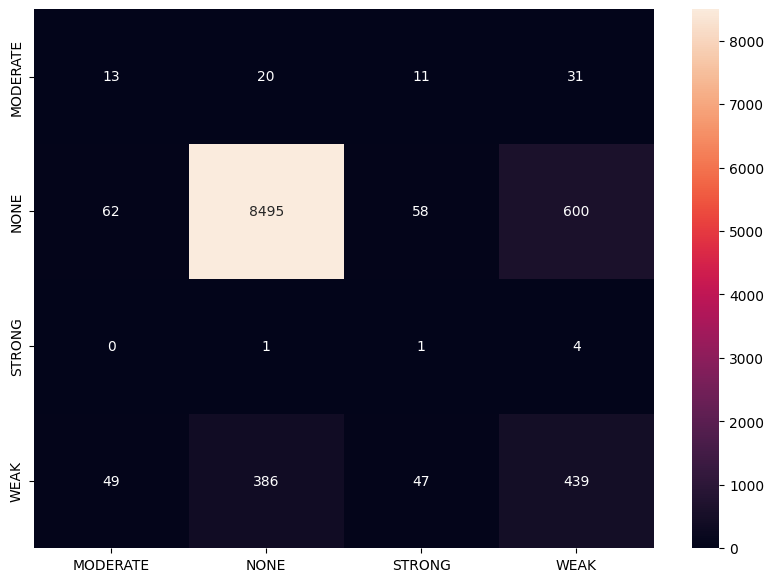

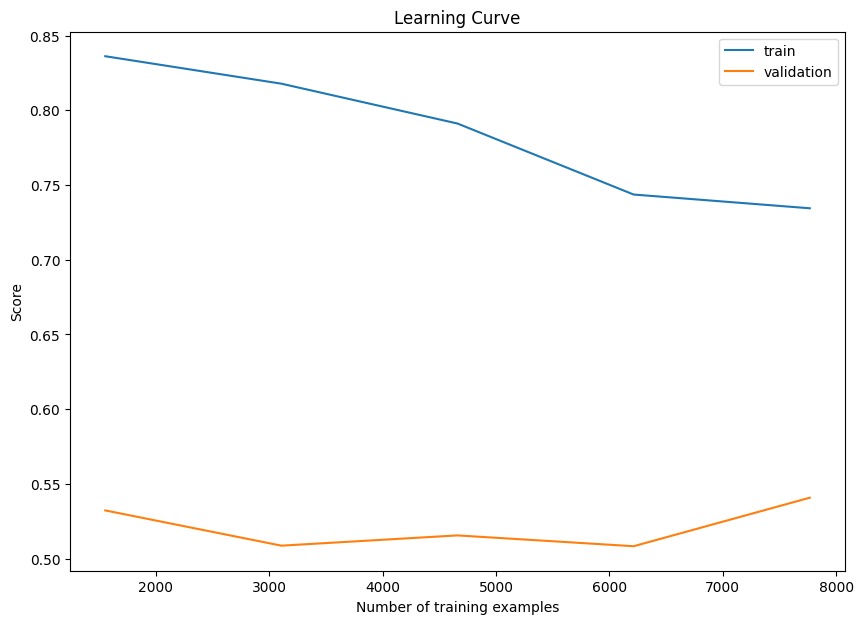

In [214]:
q2_main("A627")

### A627: Comparação dos Resultados Vanilla

| Métricas |   T1 (target == 1)  |   T2 (macro)  |
|----------------|--------|--------|
|    Acurácia    | 89.02% | 87.58% |
|    Precisão    | 45.78% | 36.91% |
|    Recall      | 64.37% | 43.46% |
|    F1          | 53.50% | 38.12% |

{'File': 'A636',
 'Classification Report': {'MODERATE': {'precision': 0.16666666666666666,
                                        'recall': 0.05454545454545454,
                                        'f1-score': 0.0821917808219178,
                                        'support': 110.0},
                           'NONE': {'precision': 0.919143629183122,
                                    'recall': 0.9781021897810219,
                                    'f1-score': 0.9477068152593228,
                                    'support': 9042.0},
                           'STRONG': {'precision': 0.0,
                                      'recall': 0.0,
                                      'f1-score': 0.0,
                                      'support': 9.0},
                           'WEAK': {'precision': 0.5182186234817814,
                                    'recall': 0.25728643216080405,
                                    'f1-score': 0.34385493619879115,
                         

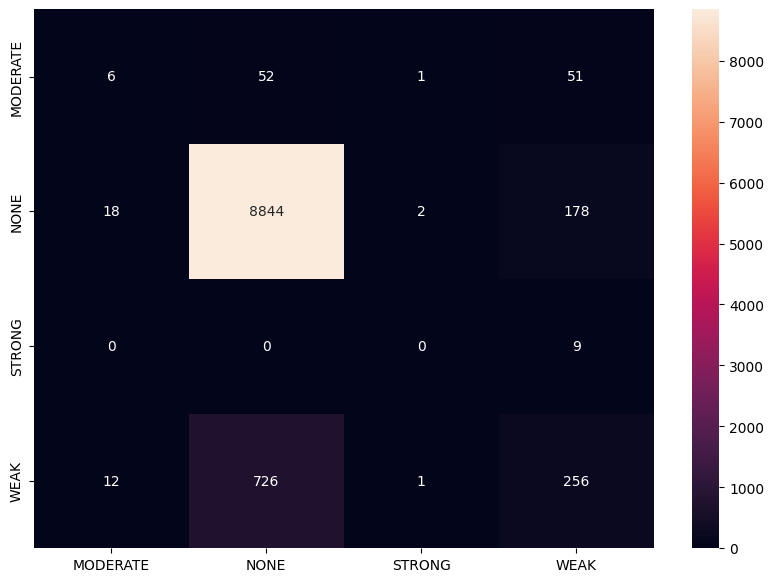

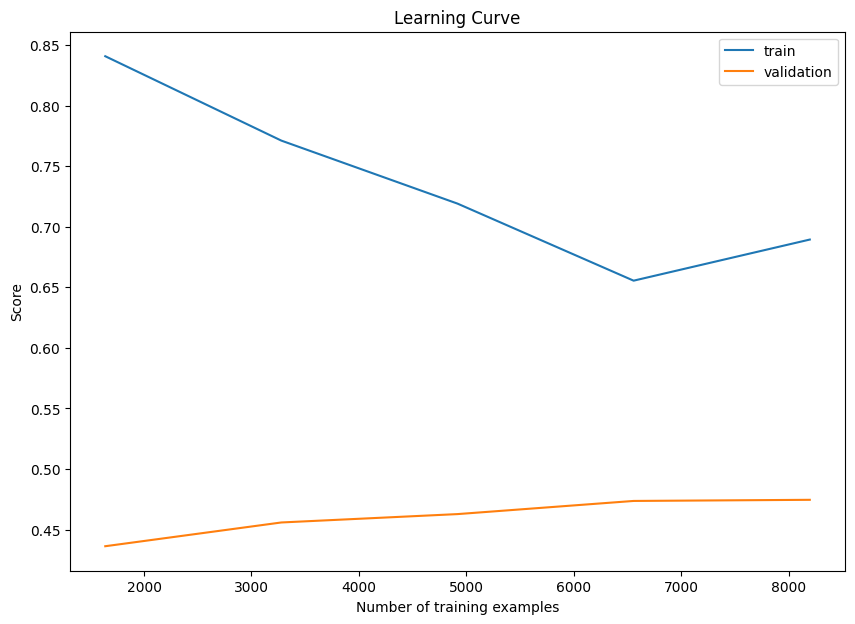

In [215]:
q2_main("A636")

### A636: Comparação dos Resultados Vanilla

| Métricas |   T1 (target == 1)  |   T2 (macro)  |
|----------------|--------|--------|
|    Acurácia    | 90.41% | 89.66% |
|    Precisão    | 59.75% | 40.10% |
|    Recall      | 38.74% | 32.25% |
|    F1          | 47.00% | 34.38% |

{'File': 'A652',
 'Classification Report': {'EXTREME': {'precision': 0.0,
                                       'recall': 0.0,
                                       'f1-score': 0.0,
                                       'support': 2.0},
                           'MODERATE': {'precision': 0.07692307692307693,
                                        'recall': 0.04,
                                        'f1-score': 0.05263157894736842,
                                        'support': 50.0},
                           'NONE': {'precision': 0.9271298066709157,
                                    'recall': 0.993964240974832,
                                    'f1-score': 0.9593844462764496,
                                    'support': 8781.0},
                           'STRONG': {'precision': 0.0,
                                      'recall': 0.0,
                                      'f1-score': 0.0,
                                      'support': 4.0},
                      

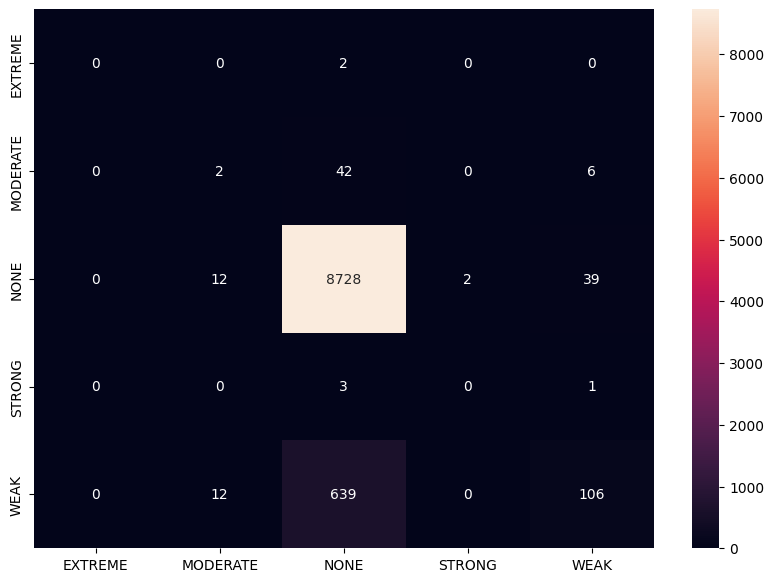

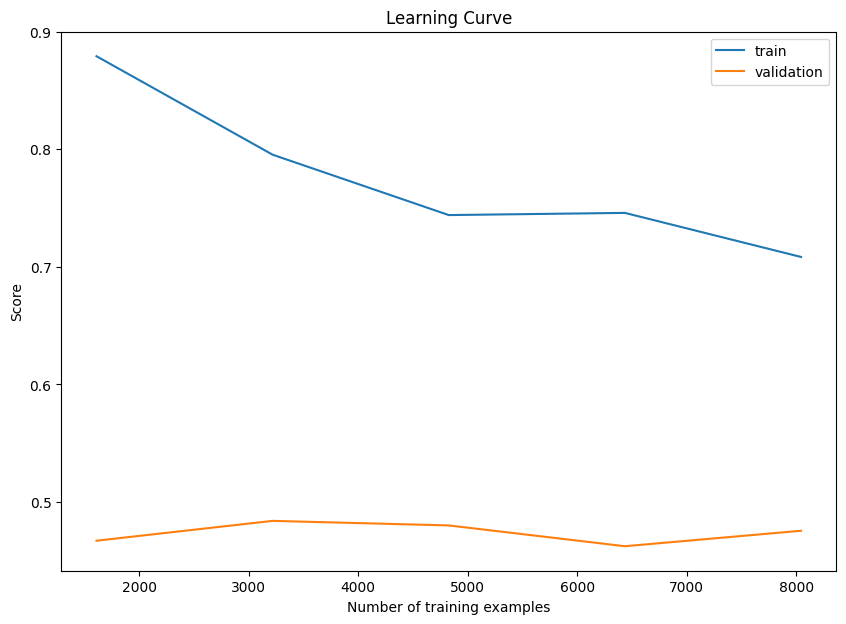

In [216]:
q2_main("A652")

### A652: Comparação dos Resultados Vanilla

| Métricas |   T1 (target == 1)  |   T2 (macro)  |
|----------|---------------------|---------------|
| Acurácia |       92.44%        |    92.10%     |
| Precisão |       69.46%        |    34.04%     |
| Recall   |       19.31%        |    23.48%     |
| F1       |       30.22%        |    24.90%     |

## 3 - SHAP Value

- Considere novamente o problema 2.
- Treine um modelo para cada estação meterológica.
- Apresente uma análise de explicabilidade do comportamento para cada modelo gerado.
- Use as sugestões de perguntas abaixo para guiar sua análise:
    - Qual a importância de cada feature para uma predição especíﬁca?
    - Como uma feature especíﬁca impacta a predição em geral?
    - Como cada feature contribui para o desempenho do modelo?
    - Quais instâncias da classe EXTREME são as mais inﬂuenciadas por uma determinada feature?
    - Quais features têm contribuições consistentes ou inconsistentes em instância da classe EXTREME?
    - Como as predições mudam com variações nas features?
    - Quais features estão mais correlacionadas com outras em termos de contribuição para as predições?
    

In [70]:
def q3_main(file_name: str) -> None:
    df_train, df_val, df_test = q2_load_datasets(file_name)

    df_concat, df_test = q2_label_target_column(
        q2_compute_precipitation_class,
        Q2_TARGET_COLUMN,
        pd.concat([df_train, df_val]),
        df_test)
    
    X_concat = df_concat.drop(Q2_TARGET_COLUMN, axis = 1)
    X_test = df_test.drop(Q2_TARGET_COLUMN, axis = 1)
    y_concat = df_concat.precipitation.values
    y_test = df_test.precipitation.values

    rfc = RandomForestClassifier(random_state = SEED)
    rfc.fit(X_concat, y_concat)
    predicted_y = rfc.predict(X_test)

    target_names = sorted(["NONE", "WEAK", "MODERATE", "STRONG", "EXTREME", "BANNED"])
    unique_target_names = set(np.unique(predicted_y)).union(np.unique(y_test))
    target_names = [x for x in target_names if x in unique_target_names]

    pprint({
        "File": file_name,
        "Classification Report": sklearn.metrics.classification_report(
            y_test, predicted_y, output_dict = True, target_names = target_names
        ),
    }, sort_dicts = False)

    explainer = shap.TreeExplainer(rfc)
    shap_values = explainer.shap_values(X_test)

    for i, class_name in enumerate(target_names):
        print(f"\nSummary plot for class {class_name}:")
        shap.summary_plot(shap_values[:, :, i], X_test)

{'File': 'A602',
 'Classification Report': {'MODERATE': {'precision': 0.0,
                                        'recall': 0.0,
                                        'f1-score': 0.0,
                                        'support': 9.0},
                           'NONE': {'precision': 0.9005524861878453,
                                    'recall': 0.9644970414201184,
                                    'f1-score': 0.9314285714285714,
                                    'support': 676.0},
                           'WEAK': {'precision': 0.4318181818181818,
                                    'recall': 0.2289156626506024,
                                    'f1-score': 0.2992125984251969,
                                    'support': 83.0},
                           'accuracy': 0.8736979166666666,
                           'macro avg': {'precision': 0.4441235560020091,
                                         'recall': 0.39780423469024023,
                                    

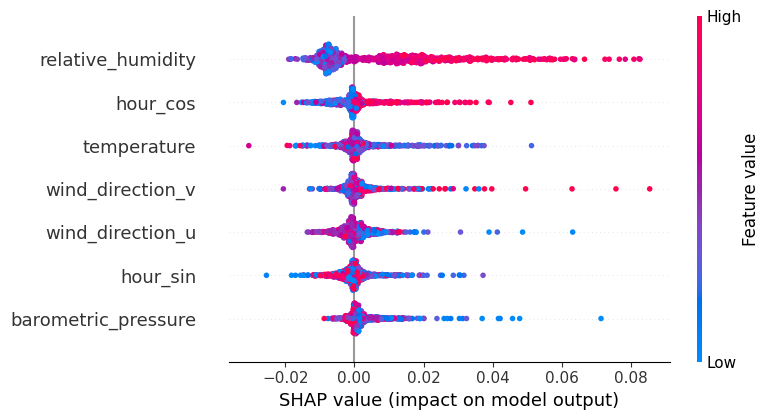


Summary plot for class NONE:


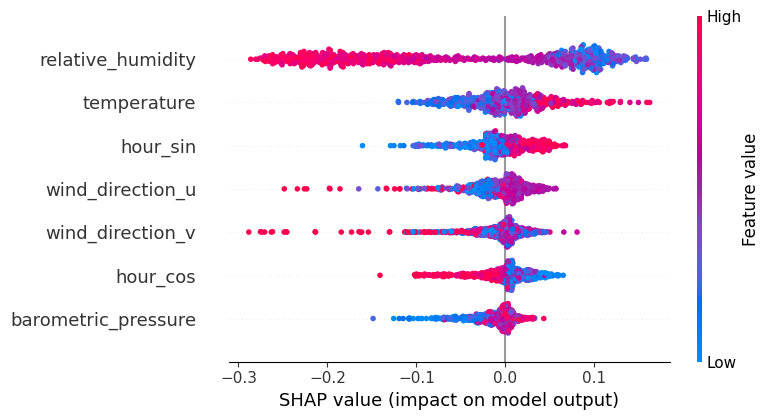


Summary plot for class WEAK:


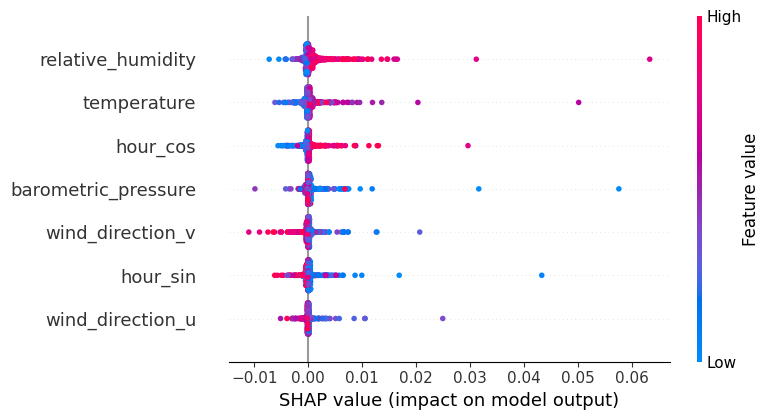

In [71]:
q3_main("A602")

{'File': 'A621',
 'Classification Report': {'EXTREME': {'precision': 0.0,
                                       'recall': 0.0,
                                       'f1-score': 0.0,
                                       'support': 1.0},
                           'MODERATE': {'precision': 0.0,
                                        'recall': 0.0,
                                        'f1-score': 0.0,
                                        'support': 75.0},
                           'NONE': {'precision': 0.9226451678742729,
                                    'recall': 0.9867932765771665,
                                    'f1-score': 0.9536416855651073,
                                    'support': 9162.0},
                           'STRONG': {'precision': 0.0,
                                      'recall': 0.0,
                                      'f1-score': 0.0,
                                      'support': 9.0},
                           'WEAK': {'precision': 0.489

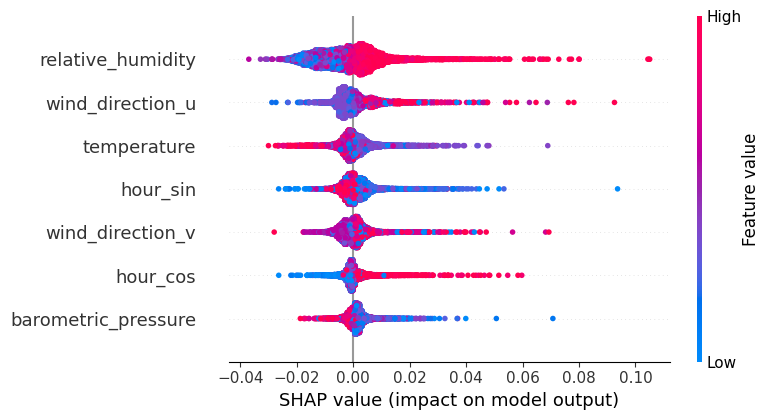


Summary plot for class MODERATE:


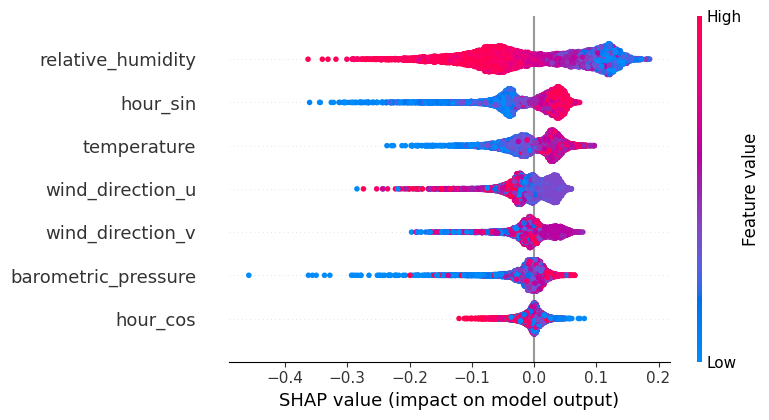


Summary plot for class NONE:


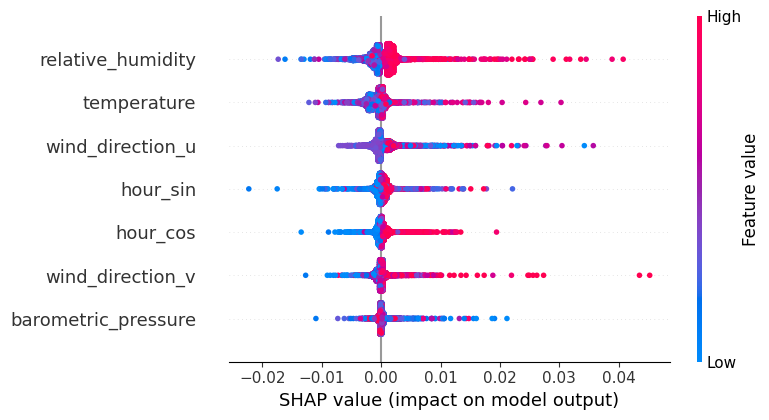


Summary plot for class STRONG:


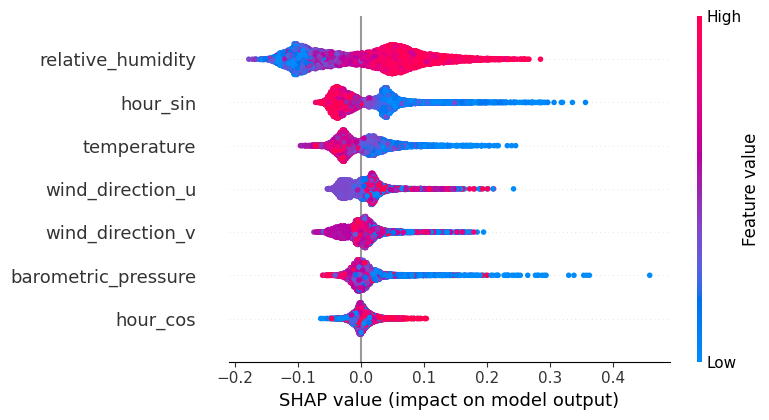


Summary plot for class WEAK:


IndexError: index 4 is out of bounds for axis 2 with size 4

In [72]:
q3_main("A621")

{'File': 'A627',
 'Classification Report': {'MODERATE': {'precision': 0.09302325581395349,
                                        'recall': 0.05333333333333334,
                                        'f1-score': 0.06779661016949153,
                                        'support': 75.0},
                           'NONE': {'precision': 0.9487823522987878,
                                    'recall': 0.942810634834509,
                                    'f1-score': 0.94578706727629,
                                    'support': 9215.0},
                           'STRONG': {'precision': 0.0,
                                      'recall': 0.0,
                                      'f1-score': 0.0,
                                      'support': 6.0},
                           'WEAK': {'precision': 0.4385447394296952,
                                    'recall': 0.48425624321389793,
                                    'f1-score': 0.4602683178534572,
                            

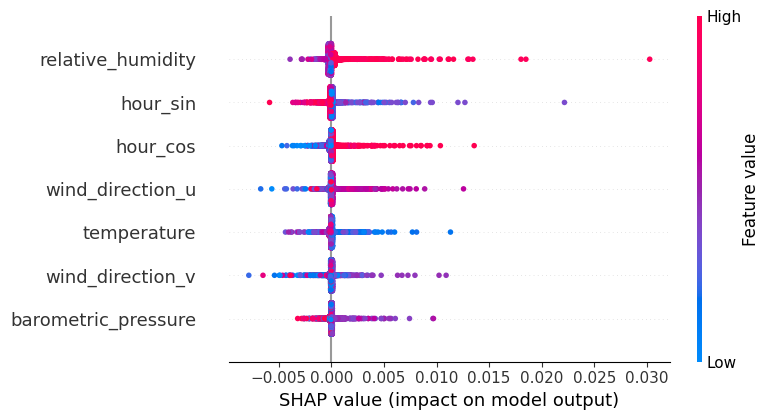


Summary plot for class NONE:


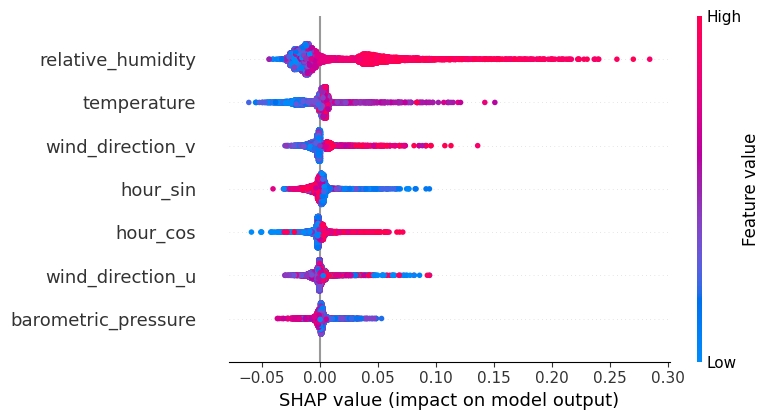


Summary plot for class STRONG:


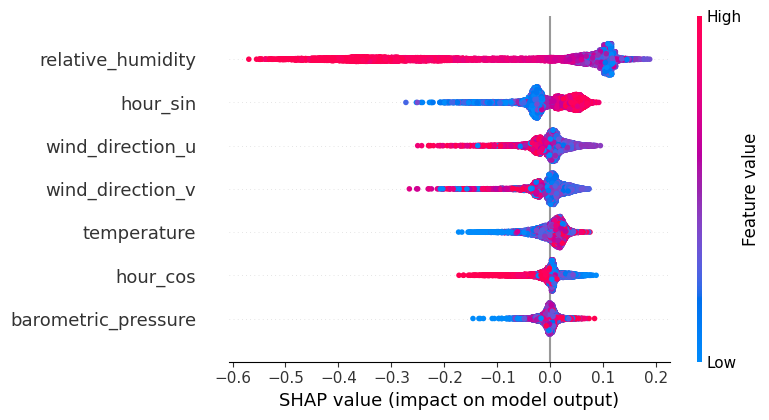


Summary plot for class WEAK:


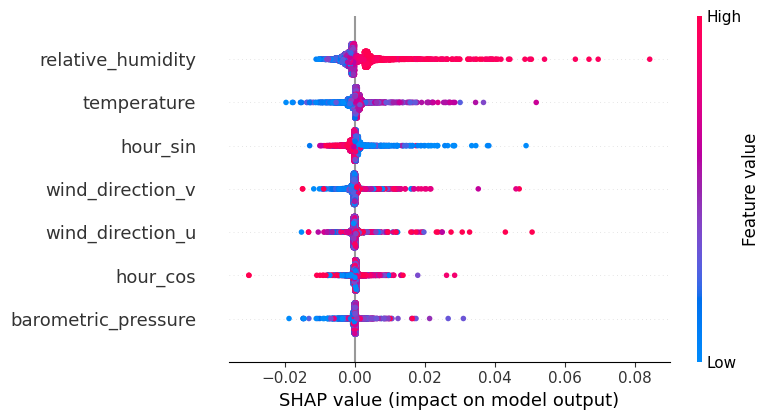

In [73]:
q3_main("A627")

{'File': 'A636',
 'Classification Report': {'EXTREME': {'precision': 0.0,
                                       'recall': 0.0,
                                       'f1-score': 0.0,
                                       'support': 1.0},
                           'MODERATE': {'precision': 0.16666666666666666,
                                        'recall': 0.00909090909090909,
                                        'f1-score': 0.017241379310344827,
                                        'support': 110.0},
                           'NONE': {'precision': 0.9219228737453777,
                                    'recall': 0.9650519796505198,
                                    'f1-score': 0.9429945426055006,
                                    'support': 9042.0},
                           'STRONG': {'precision': 0.0,
                                      'recall': 0.0,
                                      'f1-score': 0.0,
                                      'support': 9.0},
    

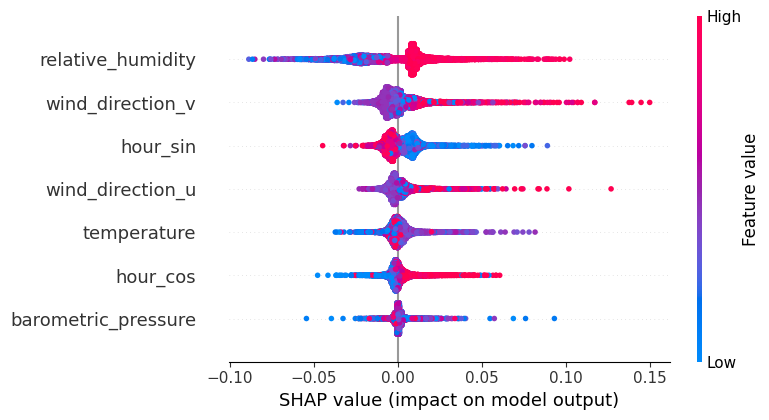


Summary plot for class MODERATE:


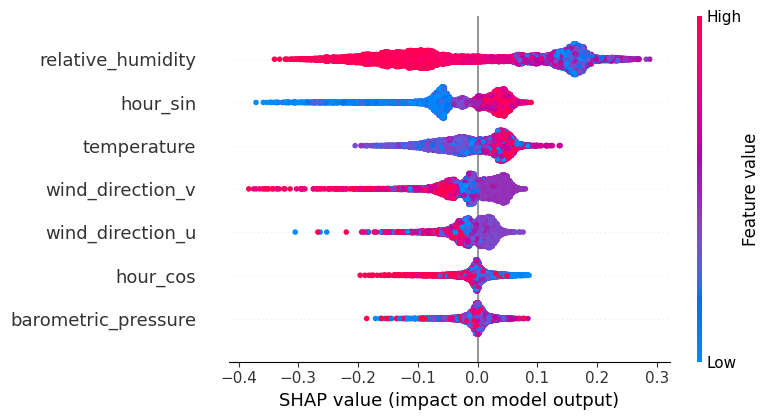


Summary plot for class NONE:


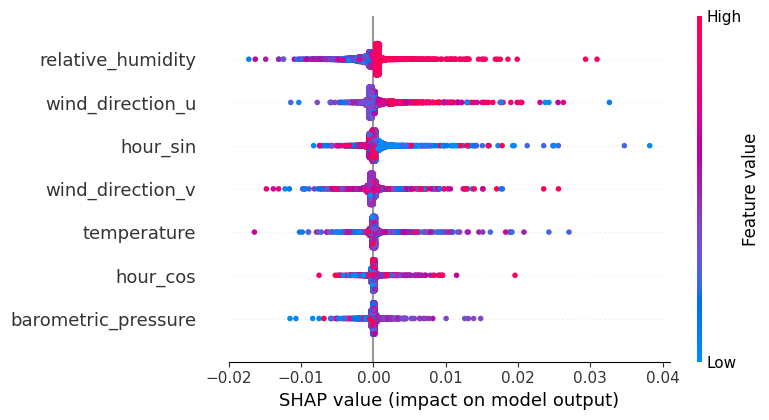


Summary plot for class STRONG:


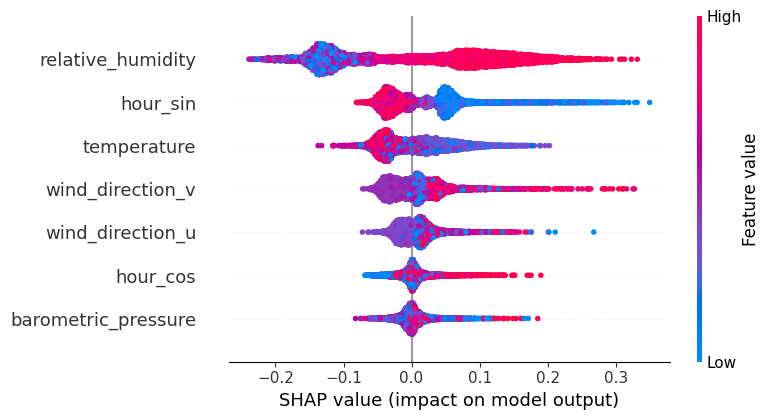


Summary plot for class WEAK:


IndexError: index 4 is out of bounds for axis 2 with size 4

In [74]:
q3_main("A636")

{'File': 'A652',
 'Classification Report': {'EXTREME': {'precision': 0.0,
                                       'recall': 0.0,
                                       'f1-score': 0.0,
                                       'support': 2.0},
                           'MODERATE': {'precision': 0.0,
                                        'recall': 0.0,
                                        'f1-score': 0.0,
                                        'support': 50.0},
                           'NONE': {'precision': 0.9263314552992452,
                                    'recall': 0.9923698895342216,
                                    'f1-score': 0.9582142071695624,
                                    'support': 8781.0},
                           'STRONG': {'precision': 0.0,
                                      'recall': 0.0,
                                      'f1-score': 0.0,
                                      'support': 4.0},
                           'WEAK': {'precision': 0.586

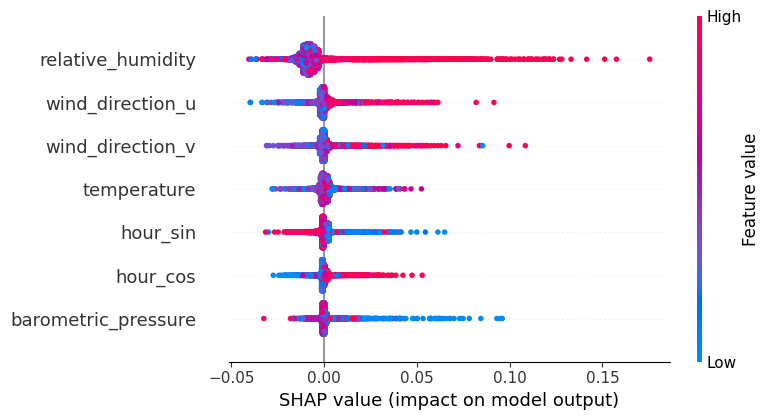


Summary plot for class MODERATE:


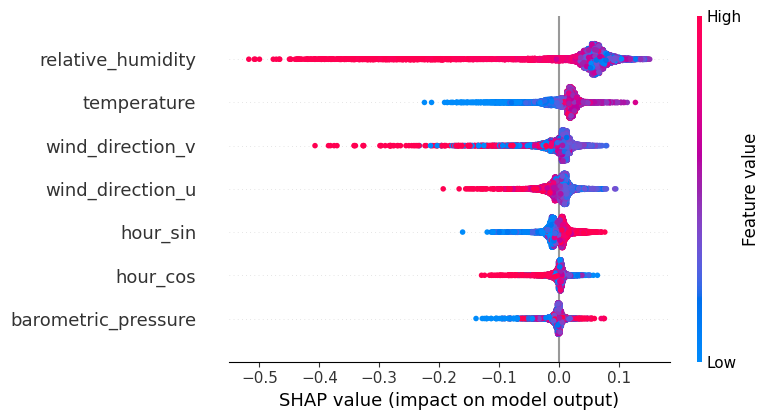


Summary plot for class NONE:


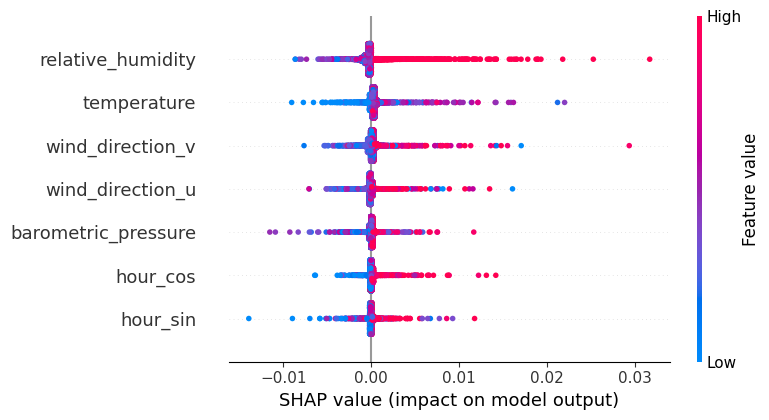


Summary plot for class STRONG:


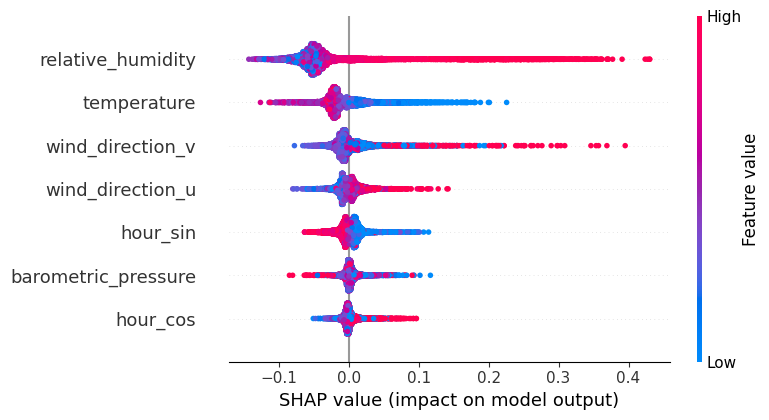


Summary plot for class WEAK:


IndexError: index 4 is out of bounds for axis 2 with size 4

In [75]:
q3_main("A652")

## 4 - Redução de dimensionalidade

- Considere novamente o problema 2.
- Realize um experimento usando o algoritmo PCA.
- Use apenas o conjunto de dados A652.
- Use validação cruzada para escolher o melhor valor para a quantidade de componentes principais.
- Assegure que não está usando o target como feature.
- Depois disso, ajuste um modelo de classificação sobre o dataset resultante da redução.
- Apresente uma análise comparativa entre o resultado encontrado por este modelo e o gerado no problema 2.

In [219]:
def plot_cumsum_explained_variance(features_df: pd.DataFrame) -> None:
    pca = PCA()
    pca.fit(features_df)
    cumsum = np.cumsum(pca.explained_variance_ratio_) * 100
    d = [n for n in range(len(cumsum))]
    plt.figure(figsize = (10, 7))
    plt.plot(d, cumsum, color = 'red', label = 'cumulative explained variance')
    plt.title('Cumulative Explained Variance as a Function of the Number of Components')
    plt.ylabel('Cumulative Explained variance')
    plt.xlabel('Principal components')
    plt.axhline(y = 95, color = 'k', linestyle = '--', label = f'95% Explained Variance')
    plt.legend(loc='best')

Best number of components: 7
Best cross-validated f1_macro: 0.4081
{'MODERATE': {'precision': 0.03225806451612903,
              'recall': 0.02,
              'f1-score': 0.024691358024691357,
              'support': 50.0},
 'NONE': {'precision': 0.9237496000853151,
          'recall': 0.9864480127548115,
          'f1-score': 0.9540698314792379,
          'support': 8781.0},
 'WEAK': {'precision': 0.45555555555555555,
          'recall': 0.1083223249669749,
          'f1-score': 0.17502668089647813,
          'support': 757.0},
 'accuracy': 0.9120775969962454,
 'macro avg': {'precision': 0.47052107338566657,
               'recall': 0.37159011257392877,
               'f1-score': 0.3845959568001358,
               'support': 9588.0},
 'weighted avg': {'precision': 0.8821353459668871,
                  'recall': 0.9120775969962454,
                  'f1-score': 0.8877155773424128,
                  'support': 9588.0}}


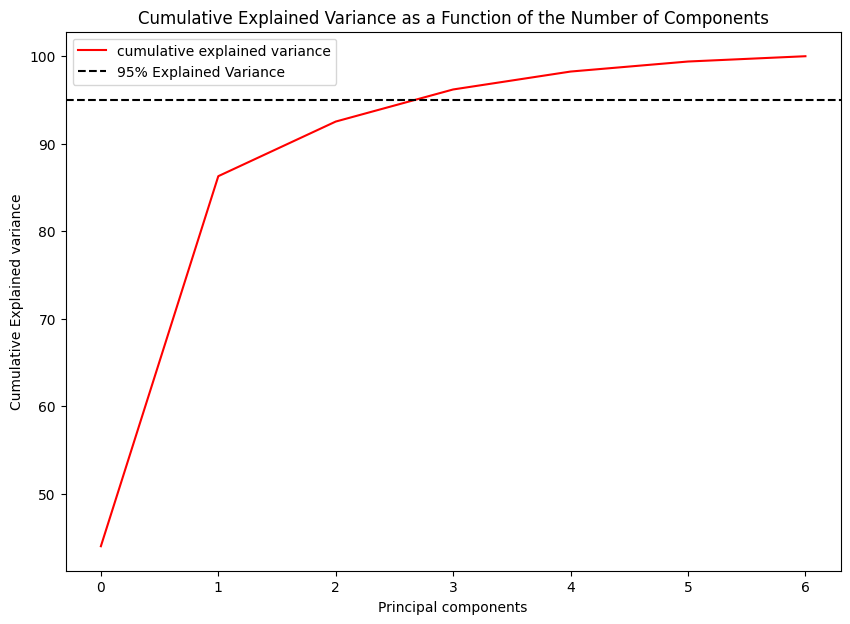

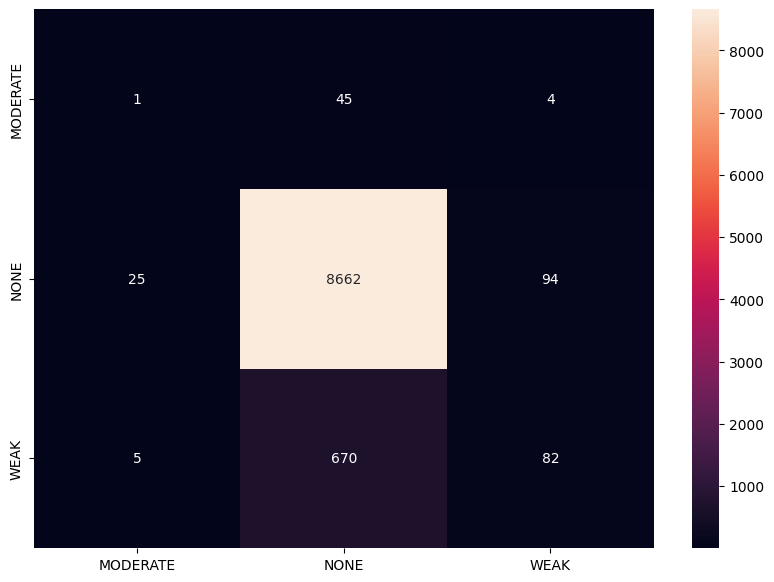

In [222]:
def q4_main() -> None:
    df_train, df_val, df_test = q2_load_datasets("A652")
    df_concat, df_test = q2_label_target_column(
        q2_compute_precipitation_class,
        Q2_TARGET_COLUMN,
        pd.concat([df_train, df_val]),
        df_test
    )

    cv_n_splits = 5
    df_concat = q2_precipitation_filter_classes(df_concat, cv_n_splits)
    df_test = q2_precipitation_filter_classes(df_test, cv_n_splits)

    X_concat = df_concat.drop(Q2_TARGET_COLUMN, axis=1)
    y_concat = df_concat.precipitation.values
    X_test = df_test.drop(Q2_TARGET_COLUMN, axis=1)
    y_test = df_test.precipitation.values

    plot_cumsum_explained_variance(X_concat)

    pipeline = sklearn.pipeline.Pipeline([
        ("pca", PCA()),
        ("classifier", GradientBoostingClassifier(validation_fraction = 0.1, n_iter_no_change = 10))
    ])

    param_grid = {
        "pca__n_components": np.arange(1, X_concat.shape[1] + 1)
    }

    grid_search = sklearn.model_selection.GridSearchCV(pipeline, param_grid, cv = cv_n_splits, scoring = "f1_macro")
    grid_search.fit(X_concat, y_concat)

    best_n_components = grid_search.best_params_["pca__n_components"]
    print(f"Best number of components: {best_n_components}")
    best_score = grid_search.best_score_
    print(f"Best cross-validated f1_macro: {best_score:.4f}")


    pca = PCA(n_components = best_n_components)
    X_concat_pca = pca.fit_transform(X_concat)
    X_test = pca.transform(X_test)

    gbc = GradientBoostingClassifier(validation_fraction = 0.1, n_iter_no_change = 10)
    gbc.fit(X_concat_pca, y_concat)
    predicted_y = gbc.predict(X_test)

    target_names = sorted(["NONE", "WEAK", "MODERATE", "STRONG", "EXTREME"])
    unique_target_names = set(np.unique(predicted_y)).union(np.unique(y_test))
    target_names = [x for x in target_names if x in unique_target_names]

    pprint(sklearn.metrics.classification_report(
            y_test, predicted_y, output_dict = True, target_names = target_names
        ), sort_dicts = False)
    q2_plot_multiclass_confusion_matrix(
        sklearn.metrics.confusion_matrix(y_test, predicted_y, labels = target_names),
        target_names)

q4_main()

### Comparando com Problema 2

| Métricas Macro |   Q2   |    Q4  |
|----------------|--------|--------|
|    Acurácia    | 92.10% | 91.21% |
|    Precisão    | 34.04% | 47.05% |
|    Recall      | 23.48% | 37.16% |
|    F1          | 24.90% | 38.46% |

## 5 - Predição Conforme

- Considere novamente o dataset de preço de diamantes do T1.
- Aplique a técnica de predição conforme para produzir as predições com intervalo de confiança.
- Apresente uma análise para os exemplos do conjunto de testes que apresentarem maior e menor intervalos.

### Colunas do Conjunto de Dados:

| Atributo  | Descrição                                        | Domínio                                                  |
|-----------|--------------------------------------------------|----------------------------------------------------------|
| price     | US dollar                                        | `[$326, $18.823]`                                        |
| carat     | Weight of the diamond                            | `[0.2, 5.01]`                                            |
| cut       | Quality of the cut                               | `{Fair, Good, Very Good, Premium, Ideal}`                |
| color     | Diamond colour                                   | `[J (worst), D (best)]`                                  |
| clarity   | How clear the diamond is                         | `{I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)}`|
| x         | Length                                           | `(0mm, 10.74mm)`                                         |
| y         | Width                                            | `(0mm, 58.9mm)`                                          |
| z         | Depth                                            | `(0mm, 31.8mm)`                                          |
| depth     | Total depth percentage (z / mean(x, y))          | `[43, 79]`                                               |
| table     | Width of top of diamond relative to widest point | `[43, 95]`                                               |

In [223]:
# Loading dataset
q5_df = pd.read_csv("../data/diamonds.csv", index_col=0)
q5_X_df = q5_df.drop(["price"], axis=1)
q5_y_df = q5_df.price.values
q5_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [224]:
# Defining feature encoding pipeline

q5_transformers_list = [
    (
        "Ordinal",
        category_encoders.OrdinalEncoder(
            mapping=[
                {
                    "col": "cut",
                    "mapping": {
                        "Fair": 1,
                        "Good": 2,
                        "Very Good": 3,
                        "Premium": 4,
                        "Ideal": 5,
                    },
                },
                {
                    "col": "color",
                    "mapping": {
                        "J": 1,
                        "I": 2,
                        "H": 3,
                        "G": 4,
                        "F": 5,
                        "E": 6,
                        "D": 7,
                    },
                },
                {
                    "col": "clarity",
                    "mapping": {
                        "I1": 1,
                        "SI2": 2,
                        "SI1": 3,
                        "VS2": 4,
                        "VS1": 5,
                        "VVS2": 6,
                        "IF": 7,
                    },
                },
            ]
        ),
        ["cut", "color", "clarity"],
    )
]

q5_fe_pipeline = ColumnTransformer(
    transformers=q5_transformers_list,
    remainder="passthrough",
    verbose_feature_names_out=False,
)

In [225]:
# Encoding features
q5_encoded_X = q5_fe_pipeline.fit_transform(q5_X_df)
q5_encoded_X.head()

,cut,color,clarity,carat,depth,table,x,y,z
1,5,6,2.0,0.23,61.5,55.0,3.95,3.98,2.43
2,4,6,3.0,0.21,59.8,61.0,3.89,3.84,2.31
3,2,6,5.0,0.23,56.9,65.0,4.05,4.07,2.31
4,4,2,4.0,0.29,62.4,58.0,4.20,4.23,2.63
5,2,1,2.0,0.31,63.3,58.0,4.34,4.35,2.75


In [226]:
# Creating polynomial feature
q5_encoded_X["volume"] = q5_encoded_X["x"] * q5_encoded_X["y"] * q5_encoded_X["z"]
q5_encoded_X.head()

,cut,color,clarity,carat,depth,table,x,y,z,volume
1,5,6,2.0,0.23,61.5,55.0,3.95,3.98,2.43,38.202030
2,4,6,3.0,0.21,59.8,61.0,3.89,3.84,2.31,34.505856
3,2,6,5.0,0.23,56.9,65.0,4.05,4.07,2.31,38.076885
4,4,2,4.0,0.29,62.4,58.0,4.20,4.23,2.63,46.724580
5,2,1,2.0,0.31,63.3,58.0,4.34,4.35,2.75,51.917250


In [227]:
# Splitting data
q5_encoded_X_train, q5_encoded_X_test, q5_y_train, q5_y_test = (
    sklearn.model_selection.train_test_split(
        q5_encoded_X, q5_y_df, test_size=0.2, random_state=SEED
    )
)
q5_encoded_X_train, q5_encoded_X_calib, q5_y_train, q5_y_calib = (
    sklearn.model_selection.train_test_split(
        q5_encoded_X_train, q5_y_train, random_state=SEED
    )
)
q5_encoded_X_train.describe()

,cut,color,clarity,carat,depth,table,x,y,z,volume
count,32364.000000,32364.000000,32364.000000,32364.000000,32364.000000,32364.000000,32364.000000,32364.000000,32364.000000,32364.000000
mean,3.912032,4.406007,3.469689,0.800027,61.743731,57.457715,5.736977,5.741017,3.541860,130.207738
std,1.115306,1.696998,1.813912,0.473957,1.432672,2.233874,1.120750,1.160011,0.713532,79.376344
min,1.000000,1.000000,-1.000000,0.200000,43.000000,49.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,3.000000,2.000000,0.400000,61.000000,56.000000,4.720000,4.730000,2.910000,65.390976
50%,4.000000,4.000000,4.000000,0.700000,61.800000,57.000000,5.700000,5.710000,3.530000,114.983046
75%,5.000000,6.000000,5.000000,1.040000,62.500000,59.000000,6.540000,6.540000,4.040000,171.086968
max,5.000000,7.000000,7.000000,5.010000,79.000000,95.000000,10.740000,58.900000,31.800000,3840.598060


In [228]:
# Scaling data
q5_encoded_column_names_backup = q5_encoded_X_train.columns
q5_scaler = MinMaxScaler()
q5_scaled_X_train = pd.DataFrame(
    q5_scaler.fit_transform(q5_encoded_X_train), columns=q5_encoded_column_names_backup
)
q5_scaled_X_calib = pd.DataFrame(
    q5_scaler.transform(q5_encoded_X_calib), columns=q5_encoded_column_names_backup
)
q5_scaled_X_test = pd.DataFrame(
    q5_scaler.transform(q5_encoded_X_test), columns=q5_encoded_column_names_backup
)
q5_scaled_X_train.head()

,cut,color,clarity,carat,depth,table,x,y,z,volume
40286,1.00,0.500000,0.625,0.020790,0.533333,0.108696,0.399441,0.073514,0.084277,0.012962
4259,0.50,0.166667,0.750,0.145530,0.563889,0.217391,0.567970,0.102886,0.121069,0.037056
15763,1.00,0.333333,0.625,0.209979,0.552778,0.173913,0.633147,0.114601,0.133962,0.050912
48293,1.00,0.500000,0.750,0.070686,0.488889,0.152174,0.491620,0.090153,0.100943,0.023433
12586,0.75,0.166667,0.500,0.230769,0.527778,0.195652,0.652700,0.118506,0.136478,0.055292


In [229]:
# Model training

q5_models = [
    GradientBoostingRegressor(random_state=SEED),
    LGBMRegressor(objective="quantile", alpha=0.5, random_state=SEED, verbosity=-1),
]

q5_training_r2 = {}

for model in q5_models:
    model.fit(q5_scaled_X_train, q5_y_train)
    q5_training_r2[model.__class__.__name__] = model.score(
        q5_scaled_X_train, q5_y_train
    )

print("Training accuracies")
pprint(q5_training_r2, sort_dicts=False)

Training accuracies
{'GradientBoostingRegressor': 0.9750423796661446,
 'LGBMRegressor': 0.9780716357695528}


In [230]:
def evaluate_regressor(model, X_test, y_test):
    pred_y = model.predict(X_test)
    pprint(
        {
            "Model": model.__class__.__name__,
            "MSE": sklearn.metrics.mean_squared_error(y_test, pred_y),
            "RMSE": sklearn.metrics.root_mean_squared_error(y_test, pred_y),
            "R^2": sklearn.metrics.r2_score(y_test, pred_y),
        },
        sort_dicts=False,
    )

In [231]:
for model in q5_models:
    evaluate_regressor(model, q5_scaled_X_test, q5_y_test)

{'Model': 'GradientBoostingRegressor',
 'MSE': 412884.8289104956,
 'RMSE': 642.5611479933218,
 'R^2': 0.9740272085098005}
{'Model': 'LGBMRegressor',
 'MSE': 356345.8800387777,
 'RMSE': 596.9471333700981,
 'R^2': 0.97758382824319}


In [232]:
mapie = MapieQuantileRegressor(q5_models[1], method="quantile", cv="split", alpha=0.2)
mapie.fit(
    q5_scaled_X_train,
    q5_y_train,
    X_calib=q5_scaled_X_calib,
    y_calib=q5_y_calib,
    random_state=SEED,
)
y_pred, y_pis = mapie.predict(q5_scaled_X_test)

In [233]:
def sort_y_values(y_test, y_pred, y_pis):
    """
    Sorting the dataset in order to make plots using the fill_between function.
    """
    indices = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[indices]
    y_pred_sorted = y_pred[indices]
    y_lower_bound = y_pis[:, 0, 0][indices]
    y_upper_bound = y_pis[:, 1, 0][indices]
    return y_test_sorted, y_pred_sorted, y_lower_bound, y_upper_bound


def plot_prediction_intervals(
    title,
    axs,
    y_test_sorted,
    y_pred_sorted,
    lower_bound,
    upper_bound,
    coverage,
    width,
    num_plots_idx,
):
    """
    Plot of the prediction intervals for each different conformal
    method.
    """
    axs.yaxis.set_major_formatter(FormatStrFormatter("%.0f" + "k"))
    axs.xaxis.set_major_formatter(FormatStrFormatter("%.0f" + "k"))

    lower_bound_ = np.take(lower_bound, num_plots_idx)
    y_pred_sorted_ = np.take(y_pred_sorted, num_plots_idx)
    y_test_sorted_ = np.take(y_test_sorted, num_plots_idx)

    error = y_pred_sorted_ - lower_bound_

    warning1 = y_test_sorted_ > y_pred_sorted_ + error
    warning2 = y_test_sorted_ < y_pred_sorted_ - error
    warnings = warning1 + warning2
    axs.errorbar(
        y_test_sorted_[~warnings],
        y_pred_sorted_[~warnings],
        yerr=np.abs(error[~warnings]),
        capsize=5,
        marker="o",
        elinewidth=2,
        linewidth=0,
        label="Inside prediction interval",
    )
    axs.errorbar(
        y_test_sorted_[warnings],
        y_pred_sorted_[warnings],
        yerr=np.abs(error[warnings]),
        capsize=5,
        marker="o",
        elinewidth=2,
        linewidth=0,
        color="red",
        label="Outside prediction interval",
    )
    axs.scatter(
        y_test_sorted_[warnings],
        y_test_sorted_[warnings],
        marker="*",
        color="green",
        label="True value",
    )
    axs.set_xlabel("True house prices in $")
    axs.set_ylabel("Prediction of house prices in $")
    ab = AnnotationBbox(
        TextArea(
            f"Coverage: {np.round(coverage, 3)}\n"
            + f"Interval width: {np.round(width, 3)}"
        ),
        xy=(np.min(y_test_sorted_) * 3, np.max(y_pred_sorted_ + error) * 0.95),
    )
    lims = [
        np.min([axs.get_xlim(), axs.get_ylim()]),  # min of both axes
        np.max([axs.get_xlim(), axs.get_ylim()]),  # max of both axes
    ]
    axs.plot(lims, lims, "--", alpha=0.75, color="black", label="x=y")
    axs.add_artist(ab)
    axs.set_title(title, fontweight="bold")

In [234]:
(y_test_sorted, y_pred_sorted, lower_bound, upper_bound) = sort_y_values(
    q5_y_test, y_pred, y_pis
)

coverage = regression_coverage_score(q5_y_test, y_pis[:, 0, 0], y_pis[:, 1, 0])

width = regression_mean_width_score(y_pis[:, 0, 0], y_pis[:, 1, 0])

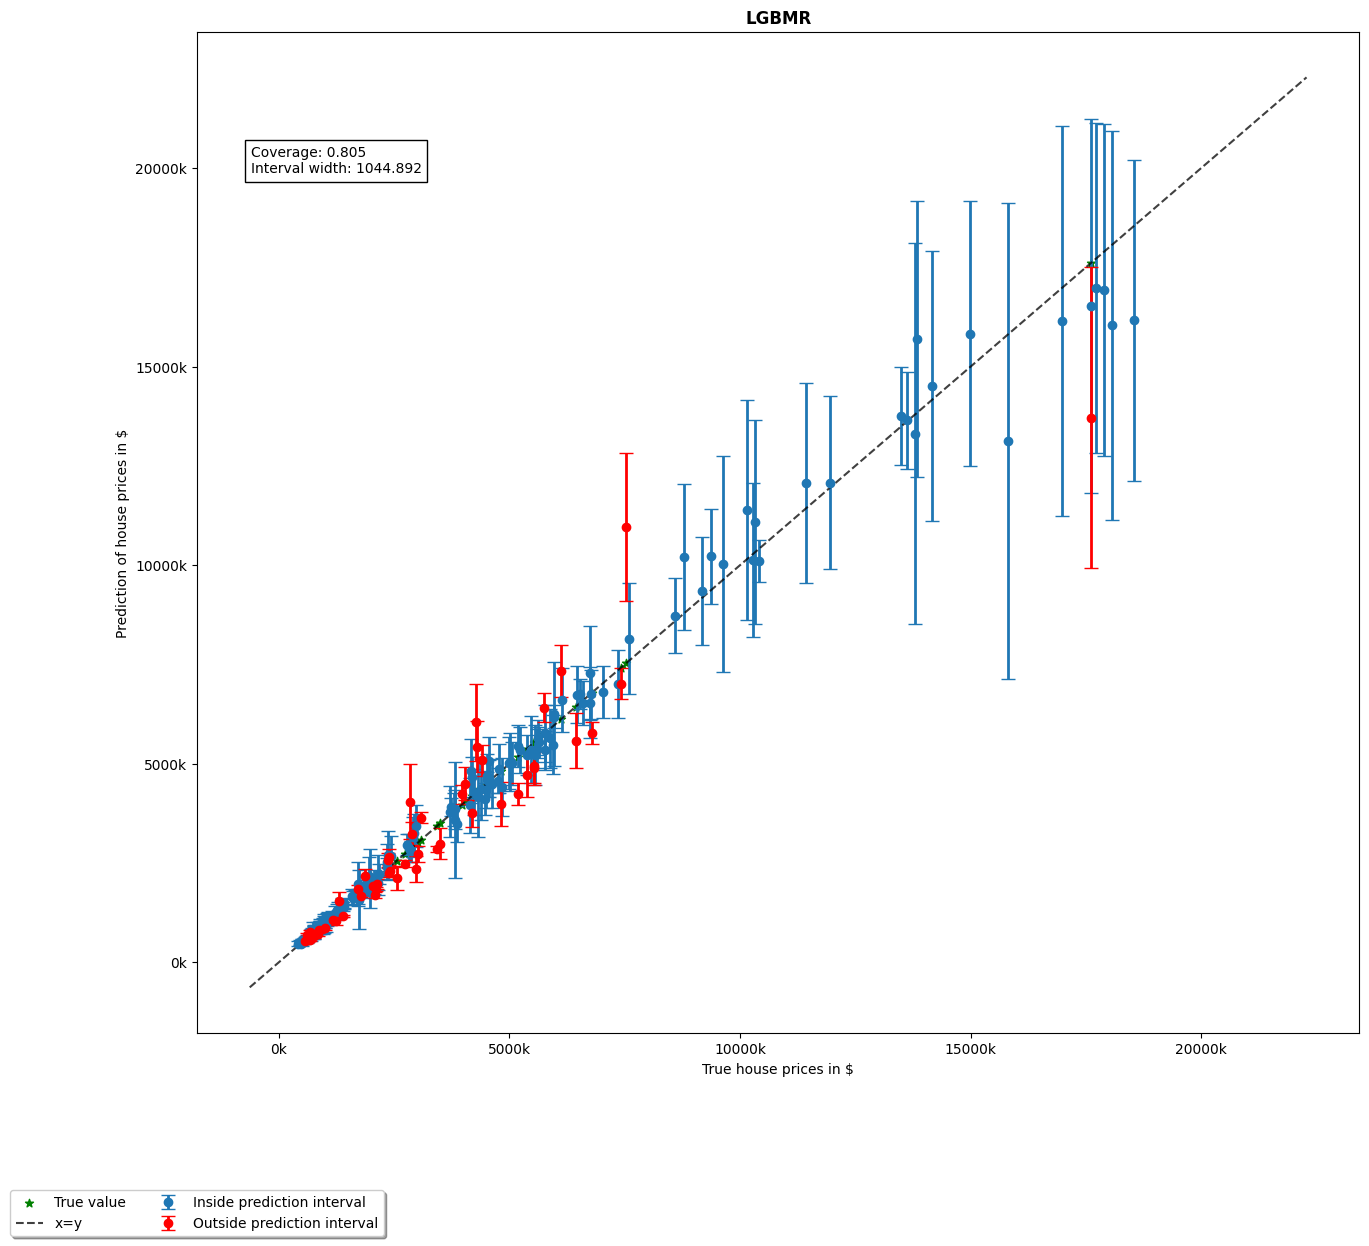

In [235]:
perc_obs_plot = 0.02
num_plots = np.random.default_rng(SEED).choice(
    len(q5_y_test), int(perc_obs_plot * len(q5_y_test)), replace=False
)

fig, ax = plt.subplots(figsize=(15, 13))  # Using a single plot

plot_prediction_intervals(
    "LGBMR",
    ax,  # Using ax instead of axs[0, 0]
    y_test_sorted,
    y_pred_sorted,
    lower_bound,
    upper_bound,
    coverage,
    width,
    num_plots,
)

# Get legend handles and labels
handles, labels = ax.get_legend_handles_labels()

# Create legend
ax.legend(
    handles[:4],
    labels[:4],
    loc="upper center",
    bbox_to_anchor=(0, -0.15),
    fancybox=True,
    shadow=True,
    ncol=2,
)

plt.show()